### **Imports**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

#from tensorflow.keras.applications.imagenet_utils import preprocess_input
#from keras.applications.vgg16 import preprocess_input, decode_prediction
from tensorflow.keras.regularizers import *
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
'''
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
'''
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)



### **Mount & set directory**


In [0]:
home_dir = '..\\'
baum_dir = home_dir + 'BAUM\\'

data = pd.read_csv(baum_dir + 'training_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})

data = shuffle(data)
data_valid = shuffle(data_valid)
'''
print("Original data", len(data),  len(data_valid))
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

def sampling_k_elements_valid(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

data = data.groupby('code').apply(sampling_k_elements).reset_index(drop=True)
data_valid = data_valid.groupby('code').apply(sampling_k_elements_valid).reset_index(drop=True)
print("Less data", len(data),  len(data_valid))

data = shuffle(data)
data_valid = shuffle(data_valid)
#ax3 = data['code'].plot.hist(bins=12)
'''

'\nprint("Original data", len(data),  len(data_valid))\ndef sampling_k_elements(group, k=4000):\n    if len(group) < k:\n        return group\n    return group.sample(k)\n\ndef sampling_k_elements_valid(group, k=1000):\n    if len(group) < k:\n        return group\n    return group.sample(k)\n\ndata = data.groupby(\'code\').apply(sampling_k_elements).reset_index(drop=True)\ndata_valid = data_valid.groupby(\'code\').apply(sampling_k_elements_valid).reset_index(drop=True)\nprint("Less data", len(data),  len(data_valid))\n\ndata = shuffle(data)\ndata_valid = shuffle(data_valid)\n#ax3 = data[\'code\'].plot.hist(bins=12)\n'

In [0]:
data.head()

,flow,spatial,emotion,code
32329,imgs_flow\s020\S020_059\001.png,imgs_spatial\s020\S020_059\001.png,Anger,1
42616,imgs_flow\s026\S026_063\038.png,imgs_spatial\s026\S026_063\038.png,Fear,3
47121,imgs_flow\s031\S031_053\037.png,imgs_spatial\s031\S031_053\037.png,Surprise,6
33869,imgs_flow\s021\S021_063\017.png,imgs_spatial\s021\S021_063\017.png,Fear,3
33679,imgs_flow\s021\S021_055\050.png,imgs_spatial\s021\S021_055\050.png,Sadness,5


### **Data Analysis and Visualization**

Unique classes are:  ['1', '3', '6', '5', '4', '2']
..\BAUM\imgs_spatial\s014\S014_030\025.png
..\BAUM\imgs_spatial\s002\S002_038\382.png
..\BAUM\imgs_spatial\s015\S015_056\011.png
..\BAUM\imgs_spatial\s006\S006_050\084.png
..\BAUM\imgs_spatial\s021\S021_027\021.png
..\BAUM\imgs_spatial\s007\S007_045\038.png
..\BAUM\imgs_spatial\s010\S010_026\058.png
..\BAUM\imgs_spatial\s001\S001_011\189.png
..\BAUM\imgs_spatial\s015\S015_053\014.png
..\BAUM\imgs_spatial\s020\S020_044\011.png


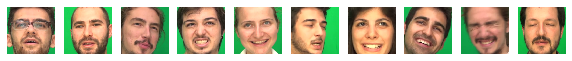

['Happiness', 'Happiness', 'Happiness', 'Disgust', 'Happiness', 'Fear', 'Happiness', 'Happiness', 'Disgust', 'Anger']


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
data_unique = data['code'].unique().tolist()
print("Unique classes are: ",data_unique)

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
  
  sample = data.sample()
  spatial = sample['spatial'] 
  emotion = sample['emotion'] 
  code = sample['code']

  spatial = spatial.values[0]
  emotion = emotion.values[0]
  code = code.values[0]

  img_path = baum_dir + spatial
  print (img_path)
  if (os.path.isfile(img_path)):
    images.append(mpimg.imread(img_path))
    emotions.append(emotion)
    codes.append(code)
    i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()
print(emotions)

### **Image generators**

In [0]:
train_df, valid_df = data , data_valid

batch_size_ = 512

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()
        frame = X1i[0][0]
        #cv2.imwrite( str(X1i[1][0]) +".png",frame )
        #cv2.imwrite("f.png", X2i[0][0])
        yield [X1i[0], X2i[0]], X1i[1]  #X1i[1] is the label


train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)

validation_generator_spatial_2 = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

print ("generators initiaized")


Found 47169 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
Found 47169 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
generators initiaized


### **Model & setting**

In [2]:
def create_model():
    input_spatial = Input(shape=(48,48,3))
    x = layers.Conv2D(128, (5, 5), activation='relu')(input_spatial)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    Out_spatial = layers.GlobalAveragePooling2D()(x)
    #x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    #Out_spatial = layers.Flatten()(x)

    input_flow = Input(shape=(48,48,3))
    x = layers.Conv2D(128, (5, 5), activation='relu')(input_flow)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    Out_flow = layers.GlobalAveragePooling2D()(x)
    #x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    #Out_flow = layers.Flatten()(x)

    merged = concatenate([Out_spatial, Out_flow])

    x = layers.Dense(1024, activation='relu')(merged)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.05))(x)
    x = layers.Dropout(0.1)(x)

    Out = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=[input_spatial, input_flow], outputs=[Out])
    return model


model = create_model()
print (model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 44, 44, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 44, 44, 128)  9728        input_2[0][0]                    
_____________

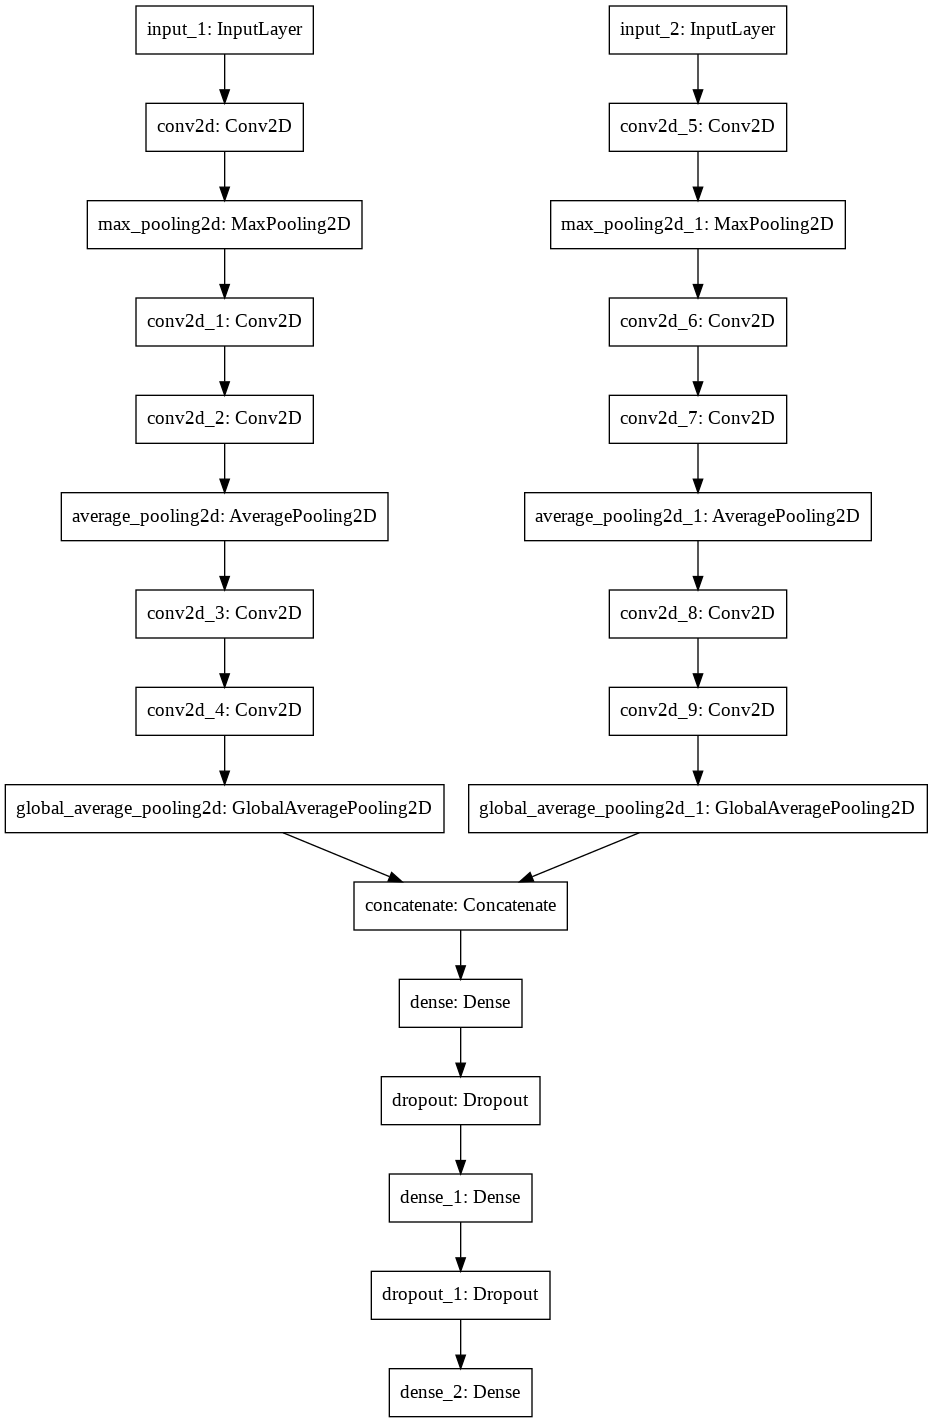

In [3]:
# Plot Model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### **Train**

In [0]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.00001, rho=0.9),
              metrics=['acc'])

In [0]:
# Auto-save model weights with best val_acc
modelPath  = baum_dir + 'models\\concatGAP.h5'
checkpoint = ModelCheckpoint(modelPath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

# Train The Model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=int(len(train_df) / batch_size_),
        epochs=50,
        #workers=8,
        #use_multiprocessing=True,
        validation_data=validation_generator,
        validation_steps=int(len(valid_df) / batch_size_),
        callbacks = callbacks_list)

Epoch 1/50
91/92 [============================>.] - ETA: 2s - loss: 51.4527 - acc: 0.3430
Epoch 00001: val_acc improved from -inf to 0.08482, saving model to ..\BAUM\models\concatGAP.h5
92/92 [==============================] - 291s 3s/step - loss: 51.4375 - acc: 0.3430 - val_loss: 50.1444 - val_acc: 0.0848
Epoch 2/50
91/92 [============================>.] - ETA: 1s - loss: 48.8230 - acc: 0.3543
Epoch 00002: val_acc did not improve from 0.08482
92/92 [==============================] - 182s 2s/step - loss: 48.8095 - acc: 0.3542 - val_loss: 47.6928 - val_acc: 0.0848
Epoch 3/50
91/92 [============================>.] - ETA: 1s - loss: 46.4056 - acc: 0.3545
Epoch 00003: val_acc did not improve from 0.08482
92/92 [==============================] - 205s 2s/step - loss: 46.3925 - acc: 0.3547 - val_loss: 45.3256 - val_acc: 0.0848
Epoch 4/50
91/92 [============================>.] - ETA: 1s - loss: 44.0734 - acc: 0.3558
Epoch 00004: val_acc did not improve from 0.08482
92/92 [=====================

Epoch 31/50
91/92 [============================>.] - ETA: 1s - loss: 7.5765 - acc: 0.4768
Epoch 00031: val_acc did not improve from 0.55441
92/92 [==============================] - 173s 2s/step - loss: 7.5730 - acc: 0.4769 - val_loss: 7.3649 - val_acc: 0.4937
Epoch 32/50
91/92 [============================>.] - ETA: 1s - loss: 6.9989 - acc: 0.4788
Epoch 00032: val_acc did not improve from 0.55441
92/92 [==============================] - 173s 2s/step - loss: 6.9964 - acc: 0.4783 - val_loss: 6.7823 - val_acc: 0.5193
Epoch 33/50
91/92 [============================>.] - ETA: 1s - loss: 6.4595 - acc: 0.4804
Epoch 00033: val_acc improved from 0.55441 to 0.57073, saving model to ..\BAUM\models\concatGAP.h5
92/92 [==============================] - 173s 2s/step - loss: 6.4573 - acc: 0.4799 - val_loss: 6.2164 - val_acc: 0.5707
Epoch 34/50
91/92 [============================>.] - ETA: 1s - loss: 5.9643 - acc: 0.4825
Epoch 00034: val_acc did not improve from 0.57073
92/92 [========================

### **End**

In [0]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


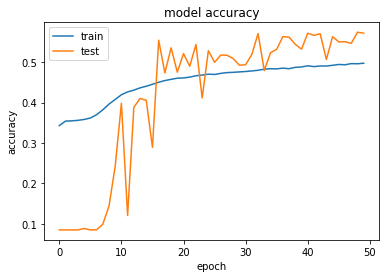

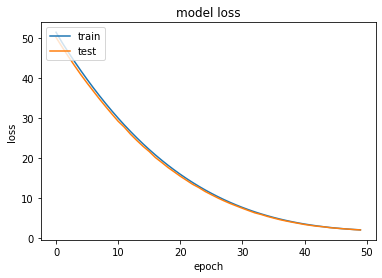

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model_path  = baum_dir + 'models\\concatGAP.h5'

# load and evaluate a saved model
model = load_model(model_path)


P = model.predict_generator(generator=validation_generator,
                                   max_queue_size =5,
                                   verbose=1,
                                   steps=len(valid_df)//batch_size_)


Instructions for updating:
Please use Model.predict, which supports generators.
14/14 [==============================] - 20s 1s/step


7168 7168


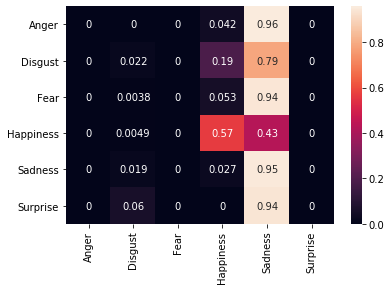

In [0]:
y_predict = np.argmax(P, axis=1)

y_true = validation_generator_spatial_2.classes[:len(y_predict)]

print(len(y_predict), len(y_true))
cm = confusion_matrix(y_true, y_predict)

lables = ['Anger' , 'Disgust' , 'Fear' , 'Happiness', 'Sadness', 'Surprise']
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, xticklabels=lables, yticklabels=lables)

In [0]:
calssifiers =['haarcascade_frontalface_default.xml',
              'haarcascade_frontalface_alt2.xml',
              'haarcascade_frontalcatface_extended.xml',
              'haarcascade_frontalcatface.xml',
              'haarcascade_frontalface_alt_tree.xml',
              'haarcascade_frontalface_alt.xml']

def detectFace(img):
    for classifier in calssifiers:
        face_cascade = cv2.CascadeClassifier(home_dir +'face_detectors/' + classifier)
        faces = face_cascade.detectMultiScale(img, 1.3, 1)
        if (len(faces) > 0):
            return faces
    faces = []
    return faces

In [0]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from random import randint
from random import seed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython import display
import os

#seed(2)
temp_image = np.array([])
none_image = None

videos = glob(baum_dir+'BAUM1s_MP4 - All\\*\\*.mp4')
emotions = ['Anger', 'Sadness', 'Surprise', 'Disgust', 'Fear', 'Happiness']

data_labels_xl =  pd.read_excel(baum_dir + "Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)

#print (vid)
# Assert Video Code
val = randint(0, len(videos)-1)
#print (len(videos))
vid = videos[val]
vidName = vid.split('\\')[-1].split('.')[0]
vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])

while vidCode not in ([1, 10, 11, 6, 7, 8]):
  val = randint(0, len(videos))
  vid = videos[val]
  vidName = vid.split('\\')[-1].split('.')[0]
  #print (vidName)
  try:
    vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
    vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])
  except:
    print ("Video Emotion Not Found")
print ('Video Name: {} Label: {}'.format(vidName, vidLabel))

video_output = baum_dir +'output.mp4'
cap = cv2.VideoCapture(vid)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_gray = cv2.resize(old_gray, (100,100))

clip = VideoFileClip(vid)

count_frames = 0
calcOpticalFlow = -1
def process_image_challenge(frame):
  global calcOpticalFlow, old_gray, count_frames
  count_frames += 1
  #if isinstance(frame, type(temp_image)) and not isinstance(frame, type(none_image)) :
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = detectFace(frame_gray)
  if len(faces) == 0:
      calcOpticalFlow = 0
      print("Old frame due to no faces")
      return frame #return original frame of video

  (x,y,w,h)  = faces[0]
  frame_gray = frame_gray[y:y+h, x:x+w]
  roi_color = frame[y:y+h, x:x+w]

  if(frame_gray.shape[0] < 90 or roi_color.shape[0] < 90 ):
      print("Old frame due to small size")
      calcOpticalFlow = 0
      return frame #return original frame of video

  frame_gray = cv2.resize(frame_gray, (100,100))
  roi_color = cv2.resize(roi_color, (100,100))

  calcOpticalFlow += 1
  hsv = np.zeros_like(roi_color)
  hsv[...,1] = 255

  if (calcOpticalFlow > 1 ):
    flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)            
    mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    flowImg = cv2.resize(rgb, (48,48))
    flowImg = flowImg/255.0
    flowImg = flowImg.reshape(-1, 48,48,3)
    roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
    spatialImg = cv2.resize(roi_color, (48,48))
    spatialImg = spatialImg/255.0
    spatialImg = spatialImg.reshape(-1, 48,48,3)
    
    out = model.predict([spatialImg, flowImg])
    org = (50, 50)   
    # fontScale 
    fontScale = 1 
    font = cv2.FONT_HERSHEY_SIMPLEX      
    # Blue color in BGR 
    color = (255, 0, 0)   
    # Line thickness of 2 px 
    thickness = 2    
    # Using cv2.putText() method 
    txt = 'Ground Truth: {}, Out: {}'.format(vidLabel, emotions[np.argmax(out[0])])
    #print ('True: {}, Out: {}, Prob.: {}'.format(vidLabel, emotions[np.argmax(out[0])], out[0]))
    frame = cv2.putText(frame, txt, org, font,  
                      fontScale, color, thickness, cv2.LINE_AA) 
 
  old_gray = frame_gray.copy()
  return frame

challenge_clip = clip.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(video_output, audio=False)
print(count_frames , frameCount)
print("The random index is ", val)


Video Name: S010_063 Label: Disgust


t:  16%|███████████████████████                                                                                                                         | 4/25 [00:00<00:00, 30.39it/s, now=None]

Moviepy - Building video ..\BAUM\output.mp4.
Moviepy - Writing video ..\BAUM\output.mp4



Moviepy - Done !
Moviepy - video ready ..\BAUM\output.mp4
Wall time: 1.25 s
26 25
The random index is  325


In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_output,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)